# Прогнозирование затрат электроэнергии на временных рядах

## Подключение библиотек

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 1. Разделение и нормализация данных

In [ ]:
file_path = './dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

scaler = MinMaxScaler()

numeric_columns = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

features = df[numeric_columns]
scaled_data = pd.DataFrame(features, columns=numeric_columns)


target = scaled_data['Global_active_power']
scaled_features = scaled_data.drop(columns=['Global_active_power'])


x_train, x_test, y_train, y_test = train_test_split(
    scaled_features, target,
    test_size=0.3, shuffle=False, random_state=42
)

def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i + time_steps].values)
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10 
x_train_seq, y_train_seq = create_sequences(x_train, y_train, time_steps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, time_steps)

## 2. Создание модели

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])  
inputs = Input(shape=input_shape)

x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64, return_sequences=False)(x)
x = Dense(25, activation='relu')(x)
outputs = Dense(1)(x)

model_lstm = Model(inputs=inputs, outputs=outputs)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

## 3. Обучение модели

In [15]:
history = model_lstm.fit(
    x_train_seq, y_train_seq,
    validation_data=(x_test_seq, y_test_seq),
    epochs=10, batch_size=32
)

Epoch 1/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 598s 13ms/step - loss: 6.9198e-04 - val_loss: 4.0712e-04
Epoch 2/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 599s 13ms/step - loss: 5.2288e-04 - val_loss: 3.8740e-04
Epoch 3/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 621s 14ms/step - loss: 4.9640e-04 - val_loss: 3.7341e-04
Epoch 4/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 696s 16ms/step - loss: 4.7446e-04 - val_loss: 4.0217e-04
Epoch 5/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 681s 15ms/step - loss: 4.6333e-04 - val_loss: 3.6618e-04
Epoch 6/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 714s 16ms/step - loss: 4.5379e-04 - val_loss: 3.7054e-04
Epoch 7/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 716s 16ms/step - loss: 4.4045e-04 - val_loss: 3.5152e-04
Epoch 8/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 643s 14ms/step - loss: 4.3568e-04 - val_loss: 3.5580e-04
Epoch 9/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 643s 14ms/step - loss: 4.3050e-04 - val_loss: 3.5654e-04
Epoch 10/10
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 649s 14ms/step - loss: 4.2808e-04 - val_loss: 

## 4. Вывод результатов

19212/19212 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step


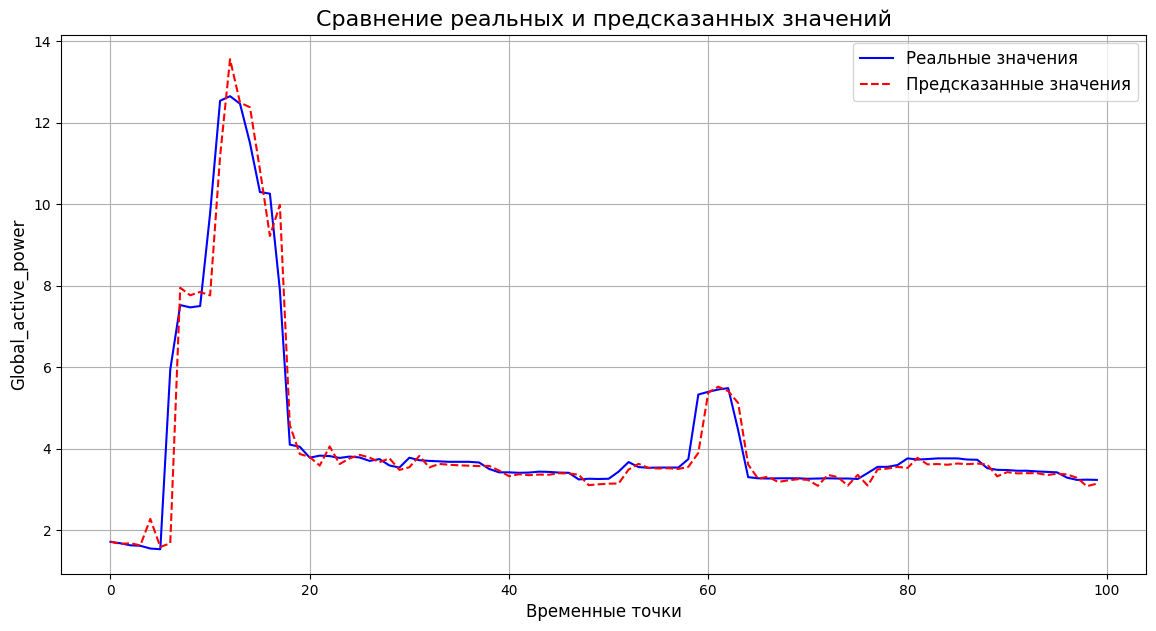

In [ ]:
predictions = model_lstm.predict(x_test_seq)

predictions_inverse = scaler.inverse_transform(
    np.hstack([x_test_seq[:, -1, :], predictions])
)[:, -1]
y_test_inverse = scaler.inverse_transform(
    np.hstack([x_test_seq[:, -1, :], y_test_seq.reshape(-1, 1)])
)[:, -1]

plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse[:100], label='Реальные значения', color='blue')
plt.plot(predictions_inverse[:100], label='Предсказанные значения', color='red', linestyle='--')
plt.title('Сравнение реальных и предсказанных значений', fontsize=16)
plt.xlabel('Временные точки', fontsize=12)
plt.ylabel('Global_active_power', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()